The cable is modeled as a horizontal cylinder in ambient air w/ natural convection heat losses calculated from the Churchill & Chu correlation and per-length resistive heating calculated as $\frac{\dot q}{L} = \frac{I^2\rho_r}{A_{section}} $.

![alt text](straight_cable.svg "basic cable")
![alt text](cable_cross_section.svg "section ")


In [370]:
pip install mpld3

Note: you may need to restart the kernel to use updated packages.


In [371]:
#import mpld3
#mpld3.enable_notebook()

In [382]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")


#To calculate the heat lost per second Q[J/s] = h*A_suface(Ts -T_fluid) of cylinder in air.
#First, we must calculate h, the heat transfer coefficient, using the Churchilll Chu correlation executed in
#function natural_convection_horiz_cy. This function needs the argument Ra, Rayleigh number, to run. 
#To calculate Ra, we multiply Gr, Grashof number, and Pr, Prandtl number. Gr is calculated using the function
#Grashof_cylinder. Then we can call natural_convection_horiz_cyl to calculate the joules lost per second. 


# Constants
g = 9.81 # m^2/s

# Cable geometry
D_copper = .014 #actual Cu D is .019 but cable not really circular (has grooves). To calc. actual circle A use D .014
D_stainless_steel = 2 * 1.4e-3
D = D_copper + D_stainless_steel # Meters; 19mm core plus 3mm thick copper jacket is worst case by a factor of ~2 compared to 1mm steel jacket
A = np.pi * D**2 / 4. # m^2

#Copper properties
rho_m = 8950.0 # kg/m^3. density of copper solid
#rho_r = 1.68e-8 # 1.724e-8 # Ohm-meters. electrical resistivity of copper at room temperature 
C = 385.0 # J/kg-K, near room temp. specific heat capacity of copper 
k = 391.1 # W/m-K  thermal conductivity of copper at room temperature

#Stainless steel properties 
rho_m_ss = 7750 #kg/m^3 depending on alloy of stainless steel 
#rho_r_ss = 6.9e-7 #ohm-m
C_ss = 470 # J/kg-K
k_ss = 15 #W/m-K

# Air properties
rho_air = 1.204 # kg/m^3
T_air = 20.0 + 273.15 # K, ~20C room temp
nu_air = 1.516e-5 # m^2/s, kinematic visc
k_air = 2.514e-2 # W/m-K, thermal cond.
beta_air = 3.69e-3 # K^-1, thermal exp. coeff., compare to 1/T ~3.4e-3
Pr_air = 0.7 # [], ranges 0.69-0.74. Not very sensitive

#Current Lead properties
rho_cl = .0001608 #ohm/m for a 4/0 gauge copper cable. not actually resisitivity. at 25 C
len_cl = 1.524 

#Connector properties 
#rho_brass = 7.1e-8 #Ohm-m at 20 C

#HTS tape and solder
#rho_HTS_tape = 8e-7 #ohm-m
#rho_solder = .153e-6 #.153 microhoms-m

# 1-D calcs
N = 400
L = np.linspace(1.0, 320.0, N) #lengths of cable from 1 to 320

# Power supply
# https://magna-power.com/assets/files/datasheets/datasheet_ts_4.4.0.pdf
I_max = 2000.0 # Amps
Vs_max_0 = 80
Vs_max = Vs_max_0 * np.ones(N) # Volts
T_s = 200.0 + 273.15 # K, surface temp

#L_Vs_max = 30.0 * np.ones(N)

def natural_convection_horiz_cyl(D, k_gas, Pr, Ra):
    """
    Churchill & Chu correlation for natural convection on a long horizontal cylinder
    
    Valid for 10^-5 < Ra < 10^12
    
    Ra should be calculated like GrPr from Gr taken as Gr = g*beta*(T_surface - T_infty)*D^3 / nu^2
    where beta is the thermal expansion coeff of the ambient gas (~1/T for ideal gases)
    Pr dimensionless number, named after the German physicist Ludwig Prandtl,
    defined as the ratio of momentum diffusivity to thermal diffusivity
    
    """
    if type(Ra) == float: 
        if Ra < 1e-5 or Ra > 1e12:
            raise ValueError("natural_convection_horiz_cyl(): Ra = {:.1e} outside of valid range (10^-5 < Ra < 10^12)".format(Ra))
    else: 
        #print("Ra", Ra)
        #print(type(Ra))
        if Ra.any() < 1e-5 or Ra.any() > 1e12:
            raise ValueError("natural_convection_horiz_cyl(): Ra = {:.1e} outside of valid range (10^-5 < Ra < 10^12)")
    
    num = 0.387 * Ra**(1./6.)
    denom = (1. + (0.559/Pr)**(9./16.))**(8./27.)
    h = (k_gas / D) * (0.6 + num/denom)**2.
    
    return h

def Grashof_cylinder(D, g, beta, dT, nu):
    """Grashof number w.r.t. diameter for cylinders. 
    g is acceleration due to Earth's gravity
    β is the coefficient of thermal expansion (equal to approximately 1/T, for ideal gases)
    Ts is the surface temperature. 200 C
    T∞ is the bulk fluid temperature which is air in this case
    D is the diameter
    ν is the kinematic viscosity of air"""
    #print("dt", dT)
    Gr = g * beta * dT * D**3. / nu**2.
    return Gr

def cu_resistivity_temp(t): 
    rho_r = 1.68e-8 *(1 + .00386 *(t - 293))
    return rho_r

def ss_resistivity_temp(t): 
    #https://calfinewire.com/datasheets/100192-stainlesssteel304/
    rho_r = 6.9e-7*(1 + .00085 *(t -293))
    return rho_r

def brass_resistivity_temp(t): 
    #https://calfinewire.com/datasheets/100192-stainlesssteel304/
    rho_r = 7.1e-8*(1 + .0015 *(t -293))
    return rho_r


#Total resistance calculations

def R_cu_cable(t, l = None): 
    if l== None: 
        R = cu_resistivity_temp(t) * L/ (np.pi * D_copper**2 / 4)
    else: 
        R = cu_resistivity_temp(t) * l/ (np.pi * D_copper**2 / 4)
    return R

def R_ss_jacket(t, l = None):
    if l== None: 
        R = ss_resistivity_temp(t)* L/ ((np.pi * .021**2 / 4)- (np.pi * .019**2 / 4))
    else: 
        R = ss_resistivity_temp(t)* l/ ((np.pi * .021**2 / 4)- (np.pi * .019**2 / 4))
    return R

def R_brass_conn(t): 
    R = brass_resistivity_temp(t) * .05/((np.pi * .027**2 / 4)- (np.pi * .021**2 / 4))
    return R

def R_ss_conn(t):
    R = ss_resistivity_temp(t) * .05/ ((np.pi * .027**2 / 4) - (np.pi * .021**2 / 4))
    return R

def R_cu_clamps(t): 
    R = cu_resistivity_temp(t) * .05/ ((np.pi * .023**2 / 4) - (np.pi * .021**2 / 4))
    return R

def R_term_lugs(t): 
    R = cu_resistivity_temp(t) * .1/ ((np.pi * .020**2 / 4) - (np.pi * .016**2 / 4))
    return R

R_current_leads = rho_cl * len_cl



def R_cable_jacket(t, l= None): 
    if l == None: 
        R_parallel = (1/R_cu_cable(t) + 1/R_ss_jacket(t))**-1
    else: 
        #print("hello")
        R_parallel = (1/R_cu_cable(t, l) + 1/R_ss_jacket(t, l))**-1 
        #print(R_parallel)
    return R_parallel

def R_total(t, l = None):
    if l == None: 
        R = 2*R_current_leads + 4*R_term_lugs(t) + R_cable_jacket(t) + 2*R_cu_clamps(t) + 2*R_ss_conn(t) + 2*R_brass_conn(t)
    else: 
        R = 2*R_current_leads + 4*R_term_lugs(t) + R_cable_jacket(t, l) + 2*R_cu_clamps(t) + 2*R_ss_conn(t) + 2*R_brass_conn(t)    
    return R


#print("Total resistance", R_total(473))
#print("cable resistance", R_cable_jacket(473))


def R_cable_jacket_temp_profile(t0, t, l): 
    R_cable_jacket_profile = np.zeros(abs(t-t0))
    T = np.arange(t0, t, 1)
               
    for i, j in zip(range(t0, t), range(abs(t-t0))): 
        #print(j)
        #print(R_cable_jacket(i, l))
        R_cable_jacket_profile[j] = R_cable_jacket(i, l) 

    return [T, R_cable_jacket_profile]


def R_total_temp_profile(t0, t, l): 
    R_total_profile = np.zeros(abs(t-t0))
    T = np.arange(t0, t, 1)
    #print(T)
    
    for i, j in zip(range(t0, t), range(abs(t-t0))): 
        R_total_profile[j] = R_total(i, l)    
    
    return [T, R_total_profile] 


Vs = Vs_max
I = Vs_max / (R_total(473)) #max current that could be flown through
I_lim_ind = np.where(I > I_max) #returns array of indices where this is true 
I[I_lim_ind] = I_max # Current limiting. forcing the I greater than I_max to equal I_max
Vs[I_lim_ind] = I[I_lim_ind] * (R_total(473)[I_lim_ind])

P_conn = I**2. * (R_total(473) - R_cable_jacket(473)) #everything that is a connection at max resistance 
P_electrical = I * Vs 
P_cable = I**2. * R_cable_jacket(473) #at max resistance


Text(0, 0.5, 'Resistance [Ohm]')

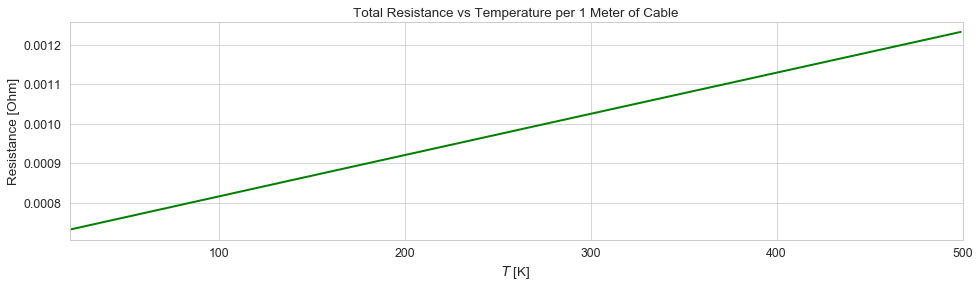

In [373]:
plt.figure(figsize=(16,4))
plt.title("Total Resistance vs Temperature per 1 Meter of Cable")
plt.plot(R_total_temp_profile(20, 500, 1)[0], R_total_temp_profile(20, 500, 1)[1], color='g', linestyle="solid", linewidth=2.0)
plt.xlim(20, 500)
plt.xlabel("$T$ [K]")
plt.ylabel("Resistance [Ohm]")


In [374]:
Gr_473 = Grashof_cylinder(D, g, beta_air, T_s - T_air, nu_air)
Ra_473 = Gr_473 * Pr_air
h_473 = natural_convection_horiz_cyl(D, k_air, Pr_air, Ra_473)
A_surface_473 = (np.pi* D**4/4 *2) + (2* np.pi* D *L)
P_conv_473 = h_473 * A_surface_473 *(T_s - T_air) #previously np.pi*D*L for the area. heat transfered per unit time


def P_conv_per_degree(t0, t, l, cool_heat):
    if cool_heat == "c": 
        T_s = np.arange(t0, t,  -1)
        T_air = np.arange(t0/2 +10, t/2 +10, - ( (t0/2+10) - (t/2+10) )/  (t0-t) )
        #T_air = 273 * np.ones(abs(t0-t))
        
    if cool_heat == "h": 
        #T_s = np.arange(t0, t, 1)
        
        T_s = 288* np.ones(abs(t0-t))
        
        #T_air = 293 * np.ones(abs(t0-t))
        
        #T_air = np.arange(t0, t/3, (t/3-t0)/(t-t0))
        T_air = 273 * np.ones(abs(t0-t))
    
    Gr_temp = np.zeros(abs(t0-t))
 
    for i in range(len(T_s)): 
        Gr_temp[i] = Grashof_cylinder(D, g, beta_air, T_s[i] - T_air[i], nu_air)
        
    #print("Gr_temp,", Gr_temp)

    Ra = Gr_temp * Pr_air
    h = natural_convection_horiz_cyl(D, k_air, Pr_air, Ra)
    A_surface = (np.pi* D**4/4 *2) + (2* np.pi* D *l)
    
    P_conv = h * A_surface *(T_s - T_air) #previously np.pi*D*L for the area. heat transfered per unit time
    #print("P_conv per degree", P_conv)
    return P_conv
    
    
    #find derivative P at every instance t. then sum up how much the power is dropping? 



def copper_heat_capacity_temp(t0, t, cool_heat):
    if cool_heat == "c": 
        T = np.arange(t0, t, -1)
    elif cool_heat == "h": 
        T = np.arange(t0, t, 1)
        
    heat_capacity = np.zeros(abs(t0-t))
    
    for i in range(len(T)): 
        heat_capacity[i] = 17.72891 + 28.09870*(T[i]/1000) - 31.25289*(T[i]/1000)**2 + 13.97243*(T[i]/1000)**3 + .068611/(T[i]/1000)**2
    
    heat_capacity = heat_capacity/ .06355 #from mol to kg 
    
    return heat_capacity

def iron_heat_capacity_temp(t0, t, cool_heat): 
    if cool_heat == "c": 
        T = np.arange(t0, t, -1)
    elif cool_heat == "h": 
        T = np.arange(t0, t, 1)
        
    heat_capacity = np.zeros(abs(t0-t))
    
    for i in range(len(T)):
        heat_capacity[i] = 18.42868 + 24.64301*(T[i]/1000) - 8.913720*(T[i]/1000)**2 + 9.664706*(T[i]/1000)**3 -.012643/(T[i]/1000)**2
    
    heat_capacity = heat_capacity/ .055845 #from mol to kg
    return heat_capacity 

def chromium_heat_capacity_temp(t0, t, cool_heat): 
    if cool_heat == "c": 
        T = np.arange(t0, t, -1)
    elif cool_heat == "h": 
        T = np.arange(t0, t, 1)
        
    heat_capacity = np.zeros(abs(t0-t))
    
    for i in range(len(T)):
        heat_capacity[i] = 7.489737 + 71.50498*(T[i]/1000) - 91.67562*(T[i]/1000)**2 + 46.04450*(T[i]/1000)**3 + .138157/(T[i]/1000)**2
    
    heat_capacity = heat_capacity/.05194 #from mol to kg 
    return heat_capacity

def stainless_steel_heat_capacity_temp(t0, t, cool_heat): 
#    if cool_heat == "c": 
#        T = np.arange(t0, t, -1)
#    elif cool_heat == "h": 
#        T = np.arange(t0, t, 1)
#        
#    heat_capacity = np.zeros(abs(t0-t))
    
#    for i in range(len(T)):
    
    heat_capacity = .1*chromium_heat_capacity_temp(t0, t, cool_heat) + .9*iron_heat_capacity_temp(t0, t, cool_heat)
    
    return heat_capacity


def Q_per_degree_for_totalT(t0, t, l, cool_heat): 
    """
    returns array of Q values. Each Q is the Q necessary to change material one degree (heat capacity). The array 
    has values for Q for the entire range t0 to t
    """
    
    C_copper_per_T = copper_heat_capacity_temp(t0, t, cool_heat)
    C_stainless_steel_per_T = stainless_steel_heat_capacity_temp(t0, t, cool_heat)
    
    m_copper = rho_m * (D_copper/2)**2 * np.pi * l
    m_stainless_steel = rho_m_ss * ( ((.021/2)**2*np.pi - (.019/2)**2* np.pi)*l)

    #print("COPPER", copper_heat_capacity_temp(t0, t, cool_heat))
    #print("STAINLESS STEEL", stainless_steel_heat_capacity_temp(t0, t, cool_heat))
    Q = (m_copper * copper_heat_capacity_temp(t0, t, cool_heat) + m_stainless_steel * stainless_steel_heat_capacity_temp(t0, t, cool_heat))* 1
    #print("Energy per degree", Q)
    return Q


#def P_conductive():
    

def time_to_temp(t0, t, l, cool_heat, insulated=None):
    """
    heat_loss_rate should be ann array with entries with units J/s
    Assumes worst case scenario with heat capacity staying constant at the highest level it will be when it is at t
    
    """
    
    if cool_heat == "c":
        time_per_degree = np.divide(Q_per_degree_for_totalT(t0, t, l, cool_heat), P_conv_per_degree(t0, t, l, cool_heat))
        #print("time per degree", time_per_degree)
        total_time = sum(time_per_degree)
        return total_time

    elif cool_heat == "h": 
    
        I_at_each_temp_list = []
        Vs_0 = Vs_max_0 * np.ones(abs(t0-t))
              
        for temp in range(t0, t): 
            I_at_each_temp_list.append(Vs_max_0 / R_total(temp, l))
        I_at_each_temp = np.asarray(I_at_each_temp_list) 

        
        I_lim_ind_0 = np.where(I_at_each_temp > I_max)
  
      
        I_at_each_temp[I_lim_ind_0] = I_max

        Vs_0[I_lim_ind_0] = I_at_each_temp[I_lim_ind_0] * R_total(temp, l)
              
        P_electrical_at_each_temp = I_at_each_temp * Vs_0
        #print("electrical", P_electrical_at_each_temp)
        #print("P conv", P_conv_per_degree(t0, t, l, cool_heat))
        if insulated == "n": 
            P_net = P_electrical_at_each_temp - P_conv_per_degree(t0, t, l, cool_heat)
        elif insulated == "y": 
            #print("print this one")
            P_net = P_electrical_at_each_temp
        #print("Net", P_net)
        #print("net power need", P_net)
        #plt.plot(L, q)
        #print("electrical",P_electrical_at_each_temp)
        #print("conv", P_conv_per_degree(t0, t, l, cool_heat))
        #print("Q", Q_per_degree_for_totalT(t0,t, l, cool_heat))
        time_per_degree = np.divide(Q_per_degree_for_totalT(t0, t, l, cool_heat), P_net)
        total_time = sum(time_per_degree)
        #print("total time", total_time)
        return total_time
        
    else:
        return TypeError 
    
    

Text(0, 0.5, 'Time [sec]')

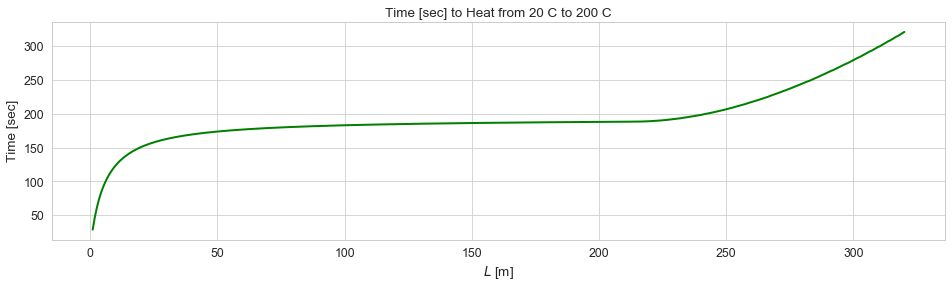

In [383]:
#print(time_to_temp(293, 453, 60.16290727, "h"))

#print(time_to_temp(293, 453, 60.96240602, "h"))

time_to_heat_L = np.zeros(len(L))      
for i in range(len(L)): 
    time_to_heat_L[i]= time_to_temp(293, 473, L[i], "h", "y")

#print(time_to_heat_L[74])
#print(time_to_heat_L[75])
#print(time_to_heat_L)

plt.figure(figsize=(16,4))
plt.title("Time [sec] to Heat from 20 C to 200 C")

plt.plot(L, time_to_heat_L, color='g', linestyle="solid", linewidth=2.0)
plt.xlabel("$L$ [m]")
plt.ylabel("Time [sec]")  
#plt.xlim(1, 5)
#plt.ylim(0, 30000)

Text(0, 0.5, 'Current [A]')

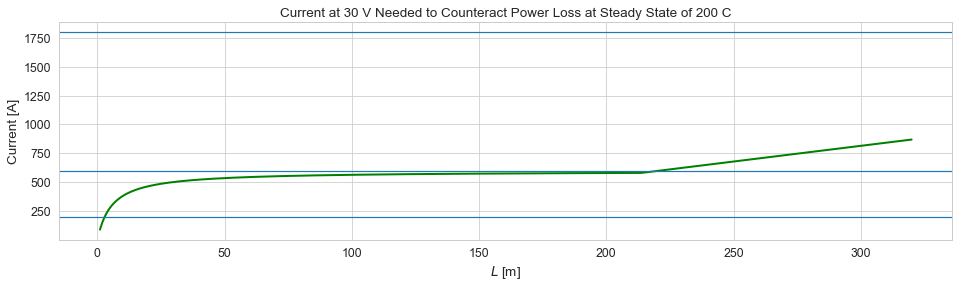

In [384]:
#print("power lost to convection", P_conv)
#print("Resistnace of copper", R_copper_200)
plt.figure(figsize=(16,4))
plt.title("Current at 30 V Needed to Counteract Power Loss at Steady State of 200 C")
plt.plot(L, P_conv_473/(Vs_max), color='g', linestyle="solid", linewidth=2.0)
plt.axhline(200)
plt.axhline(600)
plt.axhline(1800)
#plt.xlim(0, 100)
#plt.ylim(0, 3000)
plt.xlabel("$L$ [m]")
plt.ylabel("Current [A]")

Assumptions
1. Net energy is zero. P_conv = P_cable
2. Air surrounding cable is at 20 C even though it's probably much higher. However, this allows us to calculate P_conv for worst case scenario. 
3. P_conv calculated when cable is at 200 C. 
4. Voltage is maxed to 40 V on parallel power supplies. 

Text(0, 0.5, 'Time [sec]')

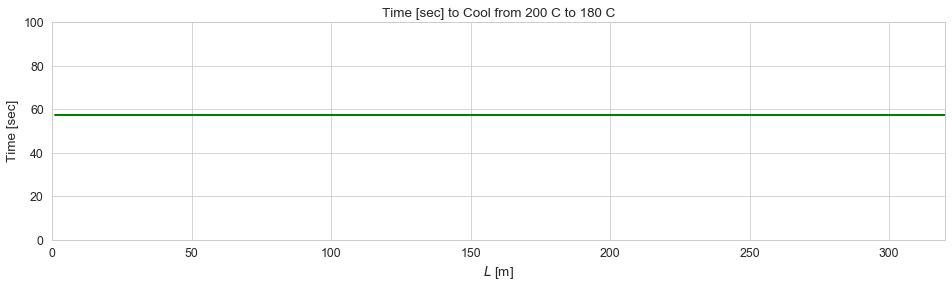

In [377]:
time_to_cool_L = np.zeros(len(L))      

   

time_to_temp(473, 253, 1, "c")
#time_to_temp(473, 253, 20, "c")


for i in range(len(L)): 
    time_to_cool_L[i]= time_to_temp(473, 453, L[i], "c")

 
plt.figure(figsize=(16,4))
plt.title("Time [sec] to Cool from 200 C to 180 C")
plt.plot(L, time_to_cool_L , color='g', linestyle="solid", linewidth=2.0)
#plt.ylim(70, 80)
plt.xlim(0, 320)
plt.ylim(0, 100)
plt.xlabel("$L$ [m]")
plt.ylabel("Time [sec]")   

Assumptions: 
1.  P_conv varies with temperature, length. So holding L constant. 
2. Do not assume surrounding air temp stays at room temp. 
3. Assume that cable is descreasing in temperature. 
    
These assumptions will allow us to see the worst case scenario in cooling. 

Net power depends on P_conv which depends on L and temp. So control for L and vary temperature. Calculate total energy necessary to get to 200 C. Then calculate minimum power necessary (longer time) at any instant. This will give us the requirements for power supply. 

In [378]:
cable_thermal_mass =  ((np.pi * D_copper**2 / 4)* L_thermal_mass_copper * rho_m * C) + ((np.pi * (D_stainless_steel - D_copper)**2 / 4)* L_thermal_mass_stainless_steel * rho_m_ss * C_ss)
dTdt_insulated = cable_thermal_mass / P_cable 
t_180_200_insulated = 20.0 * dTdt_insulated

dTdt_uninsulated = cable_thermal_mass / np.clip((P_cable - P_conv), 0.0, np.inf)
t_180_200_uninsulated = 20.0 * dTdt_uninsulated

NameError: name 'L_thermal_mass_copper' is not defined

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(L, P_electrical / L, color='k', linestyle="solid", linewidth=3., label="Electrical")
plt.plot(L, P_cable / L, color='k', linestyle="solid", linewidth=2., label="Cable Heating (Resistive)")
plt.plot(L, (P_cable - P_conv_473) / L, color='k', linestyle="--", linewidth=2., label="Cable Heating (Net)")
plt.fill_between(L, np.zeros(N), (P_cable - P_conv_473) / L, color='g', alpha=0.5, label="Heating Margin")
plt.fill_between(L, (P_cable - P_conv_473) / L, P_cable / L, color='y', alpha=0.5, label="Convective Losses")
plt.fill_between(L, P_cable / L, P_electrical / L, color='r', alpha=0.5, label="Connnector Losses")
plt.plot(L, P_conn / L, color='k', linestyle="dashdot", linewidth=2., label="Connectors [$1m\Omega$ total]")
# plt.plot(L, P_conv, color='k', linestyle="dotted", linewidth=2., label="Convective Losses")
#plt.ylim((0,1500))
plt.xlim((min(L), max(L)))
plt.xlabel("$L$ [m]")
plt.ylabel("Power Consumption per Meter [W/m]")
plt.legend(loc="upper left")

L_at_I_limit = L[np.max(np.where(I==I_max))]
plt.axvline(L_at_I_limit, color='k', linewidth=3., linestyle="--")
plt.annotate("Current-Limiting Transition", (L_at_I_limit, 900))

plt.axvline(31, color='k')
plt.annotate("CSMC", (31, 600))
plt.axvline(150, color='k')
plt.annotate("SPARC Coils", (150, 600))
plt.axvline(300, color='k')
plt.annotate("PF Coils", (300, 600))

secax = plt.gca().twinx()
plt.plot(L, I, linestyle="solid", linewidth=2., color="darkred", label="Supply Current")
secax.set_ylabel("Current [A]")
secax.set_ylim((0,4000))
plt.legend(loc="upper right")

plt.title("Uninsulated Cable Heating\n$V_{s,max} = %.1f[V]$, $I_{max} = %.0f[A]$" % (Vs_max[-1], I_max))


In [ ]:
plt.figure(figsize=(16,4))
plt.plot(L, t_180_200_insulated, color='k', linestyle="solid", linewidth=2.0, label="Insulated")
plt.plot(L, t_180_200_uninsulated, color='k', linestyle="dashed", linewidth=2.0, label="Bare")
plt.ylim((0, 1800.0))
plt.xlabel("$L$ [m]")
plt.ylabel("180C-200C Bump Time [s]")
plt.legend()

L_at_I_limit = L[np.max(np.where(I==I_max))]
plt.axvline(L_at_I_limit, color='k')
plt.annotate("Current-Limiting Transition", (L_at_I_limit, 900))

In [ ]:
N = 40
L_arr = np.linspace(1.0, 100.0, N)
Vs_arr = np.linspace(0.1, 10.0, N)
outputs = {
    "I": pd.DataFrame(np.zeros((N,N)), columns=L_arr, index=Vs_arr),
    "P_cable": pd.DataFrame(np.zeros((N,N)), columns=L_arr, index=Vs_arr),
    "P_conv": pd.DataFrame(np.zeros((N,N)), columns=L_arr, index=Vs_arr),
    "P_conn": pd.DataFrame(np.zeros((N,N)), columns=L_arr, index=Vs_arr),
    "P_electrical": pd.DataFrame(np.zeros((N,N)), columns=L_arr, index=Vs_arr),
    "t_180_200_insulated": pd.DataFrame(np.zeros((N,N)), columns=L_arr, index=Vs_arr)
}

for L, Vs in product(L_arr, Vs_arr):
    R_cable = rho_r * L / A
    I = Vs / (R_cable + R_conn)
    P_electrical = I * Vs
    P_cable = I**2. * R_cable
    P_conn = I**2. * R_conn
    
    Gr = Grashof_cylinder(D, g, beta_air, T_s - T_air, nu_air)
    Ra = Gr * Pr_air
    h = natural_convection_horiz_cyl(D, k_air, Pr_air, Ra)
    P_conv = h * np.pi * D * L * (T_s - T_air)
    
    cable_thermal_mass = A * L * rho_m * C
    dTdt_insulated = cable_thermal_mass / P_cable
    t_180_200_insulated = 20.0 * dTdt_insulated
    
    outputs["I"][L][Vs] = I
    outputs["P_cable"][L][Vs] = P_cable
    outputs["P_conv"][L][Vs] = P_conv
    outputs["P_conn"][L][Vs] = P_conn
    outputs["P_electrical"][L][Vs] = P_electrical
    outputs["t_180_200_insulated"][L][Vs] = t_180_200_insulated
    
# plt.figure(figsize=(16,9))
# cs = plt.contour(*np.meshgrid(L_arr, Vs_arr), outputs["P_cable"].values/L_arr, levels=np.logspace(0., 3.5, 11), colors='k')
# plt.clabel(cs, fmt="Insulated Net Heating %.0f [W/m]")
# plt.xlabel("$L$ [m]")
# plt.ylabel("$V_s$ [V]")

# plt.figure(figsize=(16,9))
# cs = plt.contour(*np.meshgrid(L_arr, Vs_arr), (outputs["P_cable"].values - outputs["P_conv"].values)/L_arr, colors='k', levels=np.logspace(0., 3.5, 11))
# plt.clabel(cs, fmt="Uninsulated Net Heating %.0f [W/m]")
# plt.xlabel("$L$ [m]")
# plt.ylabel("$V_s$ [V]")

# plt.figure(figsize=(16,9))
# cs = plt.contour(*np.meshgrid(L_arr, Vs_arr), outputs["t_180_200_insulated"], levels=np.logspace(0., 4., 11), colors='k')
# plt.clabel(cs, fmt="180C-200C Bump Time (Insulated) %.0f [s]")
# plt.xlabel("$L$ [m]")
# plt.ylabel("$V_s$ [V]")

In [ ]:
# Solder flow calcs
from scipy.optimize import fsolve

# Solder properties
# http://www.matweb.com/search/datasheet_print.aspx?matguid=06a31d97bb734b509043d81cf131b280
mu = 2e-3 # Pa-s, from 2cP
rho = 8600.0 # kg/m^3

# Cable core channel geometry
w = 0.3e-3 # m, channel width
h = 5.5e-3 # m, channel height
Dh = 4.0 * w * h / (2.0 * (w + h))
eps_over_Dh = 0.1 # 10% relative roughness for tape edges
A = w * h
helix_angle = np.arctan(5. / 20.)  # Approx. for 20cm pitch
Ls = np.logspace(0.0, 2.5, 101)

N = 101
P = 1e5 * np.linspace(2.0, 100., N) # Pa

def haaland(Re):
    """Haaland approximation for friction factor, roughly 10% accuracy if eps/D is known. Blended into """
    rhs = -1.8 * np.log10((eps_over_Dh/3.7)**1.11 + 6.9/Re)
    f = rhs ** -2.0
    return f

def f_bnt(Re):
    """Bellos, Nalbantis, Tsakiris friction factor approximation for all Re (smooths over transition region)"""
    a = (1.0 + (Re / 2712.0)**8.4)**-1
    b = (1.0 + (Re / (150.0 / eps_over_Dh))**1.8)**-1
    f = (64.0 / Re)**a * \
        (0.75*np.log(Re / 5.37))**(2.0 * (a - 1.0) * b) * \
        (0.88 * np.log(3.41) / eps_over_Dh)**(2.0 * (a - 1.0) * (1.0 - b))
    return f

mdot_df = pd.DataFrame(np.zeros((N, Ls.shape[0])), columns=Ls, index=P)
for L in Ls:
    L_corr = L / np.cos(helix_angle)
    def dP_from_mdot(mdot):
        v = mdot / rho / A
        Re = rho * v * Dh / mu
        f = f_bnt(Re)
        dP = f * (L_corr / Dh) * rho * v**2.0 / 2.0
        return dP

    mdot = []
    for dP in P: # Vacuum downstream -> P = dP
        def error(mdot, dP=dP):
            err = dP - dP_from_mdot_turbulent(mdot)
            return err
        mdot.append(fsolve(func=error, x0=[0.001], maxfev=int(1e4)))
    mdot = np.array(mdot)
    mdot_df[L] = mdot

plt.figure(figsize=(16,8))
for L in Ls[::20]:
    plt.plot(P/1e5, mdot_df[L].values / rho / A, color='k', linewidth=2.0)
    if L == Ls[0]:
        plt.annotate("L=%.0f [m]" % L, (max(P/1e5), max(mdot_df[L].values / rho / A)))
    else:
        plt.annotate("%.0f [m]" % L, (max(P/1e5), max(mdot_df[L].values / rho / A)))
v_turb = 4e3 / rho / Dh * mu
plt.axhline(v_turb,  color='k', linestyle="--", linewidth=2.0)
plt.annotate("Turbulent Transition", xy=(max(P/1e5), v_turb))
plt.xlim((min(P/1e5), max(P/1e5)))
plt.xlabel("Supply Pressure [bar]")
plt.ylabel("Flow Velocity [m/s]")

plt.figure(figsize=(16,8))
for dP in P[::10]:
    plt.plot(Ls, mdot_df.T[dP].values / rho / A, color='k', linewidth=2.0)
    if dP == P[::10][0] or dP == P[::10][-1]:
        plt.annotate("dP=%.0f [bar]" % (dP/1e5), (max(Ls), min(mdot_df.T[dP].values / rho / A)))
# v_turb = 4e3 / rho / Dh * mu
# plt.axhline(v_turb,  color='k', linestyle="--", linewidth=2.0)
# plt.annotate("Turbulent Transition", xy=(max(P/1e5), v_turb))
plt.xlim((min(Ls), max(Ls)))
plt.ylim((0.0, 1.0))
plt.ylabel("Flow Velocity [m/s]")
plt.xlabel("Wetted Length [m]")

In [ ]:
area_copper_former = 155 
r = (area_copper_former/np.pi)**(1/2)
print(r*2)

In [ ]:
2 * (.004 *100e-6)

In [ ]:
np.pi * D_copper**2 / 4


In [ ]:
.004 *100e-6

In [ ]:
8e-7*.1/(.004*100e-6)

In [ ]:
T = np.arange(90, 80, -1)
print(T)